In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pygad
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing as mp

## Define Grid Parameters

In [ ]:
num_nodes = 10         # Number of demand points
num_sources = 3        # Number of energy sources (e.g., solar, wind, hydro)
time_slots = 24        # 24-hour simulation
num_genes = num_nodes * num_sources * time_slots  # Total length of a chromosome
                                                  # each gene represents an allocation proportion

## Generate Synthetic Demand Matrix

In [ ]:
# Each node has different demand over 24 hours
np.random.seed(42)
demand = np.zeros((num_nodes, time_slots))
for t in range(time_slots):
    if 8 <= t <= 10 or 18 <= t <= 21:
        demand[:, t] = np.random.randint(15, 25, size=num_nodes)  # peak demand hours (like morning and evening)
    elif 0 <= t <= 5:
        demand[:, t] = np.random.randint(5, 10, size=num_nodes)   # Low demand hours (like late night/ early morning)
    else:
        demand[:, t] = np.random.randint(10, 15, size=num_nodes)  # Normal demand hours

## Generate Source Capacity and Cost Info


*   source_capacity: Maximum energy a source can provide at each time slot.
*   source_cost: Cost per unit of energy for each source.



In [ ]:
source_capacity = np.random.randint(600, 800, size=(num_sources, time_slots))
source_cost = np.array([5, 4, 6])  # cost per kWh for each source

## Generate Transmission Losses Between Sources and Nodes


*   transmission_loss: Percentage of energy lost during transmission from each source to each node.



In [ ]:
transmission_loss = np.random.uniform(0.01, 0.05, size=(num_sources, num_nodes))

## Objective Weights


*   These weights determine the importance of each objective in the fitness function.
* Higher weight means a greater penalty for that objective, guiding the GA to prioritize its minimization



In [ ]:
WEIGHT_COST = 0.3
WEIGHT_LOSS = 0.2
WEIGHT_UNMET_DEMAND = 0.4
WEIGHT_CAPACITY_VIOLATION = 0.1
WEIGHT_OVER_FULFILLMENT = 0.15 # Penalty for supplying more energy than demand (waste)

## Fitness Function

In [ ]:
def fitness_func(ga_instance, solution, sol_idx):
    """
    Calculates the fitness of a given solution (chromosome).
    The goal is to minimize total cost, energy loss, unmet demand, capacity violations,
    and over-fulfillment of demand.
    PyGAD maximizes fitness, so we return the negative of the combined objective.

    Args:
        ga_instance: The PyGAD GA instance (not directly used in this static context, but required by PyGAD).
        solution (np.array): A 1D array representing the chromosome. Each gene
                             is a float between 0.0 and 1.0, representing the
                             proportion of source capacity to allocate.
        sol_idx (int): The index of the current solution in the population.

    Returns:
        float: The fitness value (negative of the objective function).
    """

    # Decode chromosome into a 3D matrix: alloc[source][node][time_slot]
    # Each element `alloc[s, n, t]` is a proportion (0 to 1) of `source_capacity[s, t]`
    # that is allocated from source `s` to node `n` at time `t`.
    alloc = np.reshape(solution, (num_sources, num_nodes, time_slots))

    total_cost = 0.0
    total_loss = 0.0
    total_unmet_demand = 0.0
    total_capacity_violation = 0.0
    total_over_fulfillment = 0.0

    for t in range(time_slots):
        # Initialize delivered energy for each node at the current time slot
        delivered_energy_at_time_t = np.zeros(num_nodes)

        for s in range(num_sources):
            # Calculate total energy used from this source at time 't'
            # Sum of (proportion * source_capacity) for all nodes from source 's' at time 't'
            used_energy_from_source_at_t = np.sum(alloc[s, :, t] * source_capacity[s, t])

            # Check for source capacity violation and add penalty
            # This penalizes solutions where a source is instructed to provide more than its max capacity.
            if used_energy_from_source_at_t > source_capacity[s, t]:
                total_capacity_violation += (used_energy_from_source_at_t - source_capacity[s, t])

            # Ensure allocated energy is non-negative, penalize if negative (shouldn't happen with init_range_low=0.0)
            # This is a safeguard if mutation/crossover produce negative values.
            if np.any(alloc[s, :, t] < 0):
                 total_capacity_violation += np.sum(np.abs(alloc[s, :, t][alloc[s, :, t] < 0])) * 1000 # High penalty


            for n in range(num_nodes):
                # Actual energy allocated from source 's' to node 'n' at time 't'
                energy_allocated = alloc[s, n, t] * source_capacity[s, t]

                # Calculate energy loss during transmission
                energy_loss = energy_allocated * transmission_loss[s, n]

                # Energy effectively received by the node after losses
                energy_received = energy_allocated - energy_loss

                # Accumulate costs and losses
                total_cost += energy_allocated * source_cost[s]
                total_loss += energy_loss

                # Accumulate delivered energy for each node for demand fulfillment check
                delivered_energy_at_time_t[n] += energy_received

        # Calculate unmet demand for the current time slot
        # Penalizes situations where demand is higher than delivered energy
        total_unmet_demand += np.sum(np.maximum(0, demand[:, t] - delivered_energy_at_time_t))

        # Calculate over-fulfillment for the current time slot
        # Penalizes situations where delivered energy exceeds demand (implies waste or unneeded generation)
        total_over_fulfillment += np.sum(np.maximum(0, delivered_energy_at_time_t - demand[:, t]))

    # Total objective function to be minimized
    objective_value = (WEIGHT_COST * total_cost) + \
                      (WEIGHT_LOSS * total_loss) + \
                      (WEIGHT_UNMET_DEMAND * total_unmet_demand) + \
                      (WEIGHT_CAPACITY_VIOLATION * total_capacity_violation) + \
                      (WEIGHT_OVER_FULFILLMENT * total_over_fulfillment)

    # PyGAD aims to maximize the fitness function, so we negate the objective value
    # to convert a minimization problem into a maximization problem.
    return -objective_value

## Manual Fitness Calculation Example

- Manually calculates the fitness score for a given solution array. This function uses the same logic as `fitness_func` but is designed
    for standalone evaluation of any given solution.

- solution_array (np.array): A 1D array representing a candidate solution

-
    Returns:
        tuple: (fitness_score, total_cost, total_loss, total_unmet_demand,
                total_capacity_violation, total_over_fulfillment)

In [ ]:
def calculate_fitness_manually(solution_array):

    # Ensure the solution is a numpy array for consistent operations
    solution_array = np.array(solution_array)

    # Decode chromosome into a 3D matrix
    alloc = np.reshape(solution_array, (num_sources, num_nodes, time_slots))

    total_cost = 0.0
    total_loss = 0.0
    total_unmet_demand = 0.0
    total_capacity_violation = 0.0
    total_over_fulfillment = 0.0

    for t in range(time_slots):
        delivered_energy_at_time_t = np.zeros(num_nodes)
        for s in range(num_sources):
            used_energy_from_source_at_t = np.sum(alloc[s, :, t] * source_capacity[s, t])
            if used_energy_from_source_at_t > source_capacity[s, t]:
                total_capacity_violation += (used_energy_from_source_at_t - source_capacity[s, t])
            if np.any(alloc[s, :, t] < 0):
                 total_capacity_violation += np.sum(np.abs(alloc[s, :, t][alloc[s, :, t] < 0])) * 1000

            for n in range(num_nodes):
                energy_allocated = alloc[s, n, t] * source_capacity[s, t]
                energy_loss = energy_allocated * transmission_loss[s, n]
                energy_received = energy_allocated - energy_loss

                total_cost += energy_allocated * source_cost[s]
                total_loss += energy_loss
                delivered_energy_at_time_t[n] += energy_received

        total_unmet_demand += np.sum(np.maximum(0, demand[:, t] - delivered_energy_at_time_t))
        total_over_fulfillment += np.sum(np.maximum(0, delivered_energy_at_time_t - demand[:, t]))

    objective_value = (WEIGHT_COST * total_cost) + \
                      (WEIGHT_LOSS * total_loss) + \
                      (WEIGHT_UNMET_DEMAND * total_unmet_demand) + \
                      (WEIGHT_CAPACITY_VIOLATION * total_capacity_violation) + \
                      (WEIGHT_OVER_FULFILLMENT * total_over_fulfillment)

    fitness_score = -objective_value
    return fitness_score, total_cost, total_loss, total_unmet_demand, total_capacity_violation, total_over_fulfillment

## Greedy Baseline Algorithm

- This function implements a simple greedy strategy for energy allocation.
- At each time step, it attempts to fulfill demand by prioritizing the cheapest available energy source first.
- It calculates final metrics including losses and penalties

In [ ]:
def greedy_allocation_baseline():

    greedy_alloc = np.zeros((num_sources, num_nodes, time_slots))

    total_cost_greedy = 0.0
    total_loss_greedy = 0.0
    total_unmet_demand_greedy = 0.0
    total_capacity_violation_greedy = 0.0
    total_over_fulfillment_greedy = 0.0

    # Get sources sorted by cost (cheapest first)
    sorted_sources_indices = np.argsort(source_cost)

    for t in range(time_slots):
        current_demand_t = np.copy(demand[:, t]) # Demand for current time slot
        current_source_remaining_capacity = np.copy(source_capacity[:, t]) # Remaining capacity for current time slot

        # Energy received by each node for current time slot
        received_at_nodes_t = np.zeros(num_nodes)

        for s_idx in sorted_sources_indices:
            # Distribute power from this source to nodes that still have demand
            for n_idx in range(num_nodes):
                if current_demand_t[n_idx] > 0 and current_source_remaining_capacity[s_idx] > 0:
                    # Determine how much energy this source can send to this node
                    amount_to_send = min(current_demand_t[n_idx], current_source_remaining_capacity[s_idx])

                    if amount_to_send > 0:
                        greedy_alloc[s_idx, n_idx, t] = amount_to_send # This is actual energy (kW)

                        # Update remaining demand and source capacity
                        current_demand_t[n_idx] -= amount_to_send
                        current_source_remaining_capacity[s_idx] -= amount_to_send

                        # Calculate costs and losses immediately for this allocation
                        cost_part = amount_to_send * source_cost[s_idx]
                        loss_part = amount_to_send * transmission_loss[s_idx, n_idx]

                        total_cost_greedy += cost_part
                        total_loss_greedy += loss_part
                        received_at_nodes_t[n_idx] += (amount_to_send - loss_part)

        # After all sources have tried to fulfill demand at time t
        # Calculate unmet demand and over-fulfillment
        total_unmet_demand_greedy += np.sum(np.maximum(0, demand[:, t] - received_at_nodes_t))
        total_over_fulfillment_greedy += np.sum(np.maximum(0, received_at_nodes_t - demand[:, t]))

        # Check for capacity violations (should ideally be zero for greedy if capacity is handled correctly)
        actual_source_output_t = np.sum(greedy_alloc[:, :, t], axis=1)
        for s_idx in range(num_sources):
            if actual_source_output_t[s_idx] > source_capacity[s_idx, t]:
                total_capacity_violation_greedy += (actual_source_output_t[s_idx] - source_capacity[s_idx, t])

    # Calculate final objective value for the greedy solution
    objective_value = (WEIGHT_COST * total_cost_greedy) + \
                      (WEIGHT_LOSS * total_loss_greedy) + \
                      (WEIGHT_UNMET_DEMAND * total_unmet_demand_greedy) + \
                      (WEIGHT_CAPACITY_VIOLATION * total_capacity_violation_greedy) + \
                      (WEIGHT_OVER_FULFILLMENT * total_over_fulfillment_greedy)

    return objective_value, total_cost_greedy, total_loss_greedy, total_unmet_demand_greedy, total_capacity_violation_greedy, total_over_fulfillment_greedy

## Genetic Algorithm Configuration

In [ ]:
num_generations = 50     # Number of generations for the GA to evolve
num_parents_mating = 10   # Number of solutions selected as parents for reproduction
sol_per_pop = 200         # Number of solutions (chromosomes) in each population

# Gene values represent proportions of source capacity, hence they are within [0.0, 1.0]
init_range_low = 0.0
init_range_high = 1.0

# PyGAD Parallel Computing Setup:
parallel_processing_config = ["process", mp.cpu_count()] # Use all available CPU cores
# parallel_processing_config = None # Uncomment this line to run the GA in serial mode


# Initialize the PyGAD GA instance with defined parameters
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_func,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    mutation_percent_genes=5,       # Percentage of genes to mutate in each solution
    mutation_type="random",         # Type of mutation (randomly changes gene value within range)
    mutation_by_replacement=True,   # If True, mutated gene is replaced by a new random value
    crossover_type="single_point",  # Type of crossover (single point crossover)
    random_seed=42,                 # Seed for reproducibility of GA runs
    parallel_processing=parallel_processing_config # Enable/disable parallel processing
)

In [ ]:
# --- Run the Genetic Algorithm ---
print(f"Starting Genetic Algorithm optimization with {ga_instance.population.shape[0]} solutions per population "
      f"for {num_generations} generations...")
if parallel_processing_config:
    print(f"Parallel processing enabled using {parallel_processing_config[1]} {parallel_processing_config[0]}es.")
else:
    print("Parallel processing disabled (running serially).")

start_time = time.time()
ga_instance.run()
end_time = time.time()

Starting Genetic Algorithm optimization with 200 solutions per population for 50 generations...
Parallel processing enabled using 2 processes.


In [ ]:
# --- Display GA Results ---
print("\n--- Genetic Algorithm Optimization Results ---")
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print(f"Best Solution Fitness (negative of minimized objective): {best_solution_fitness:.4f}")
overall_objective_GA = -best_solution_fitness
print(f"Overall Objective Value (Cost + Loss + Unmet + Violation + Over-fulfillment) from GA: {overall_objective_GA:.4f}")
print(f"GA Execution Time: {end_time - start_time:.4f} seconds")

# Decode the best solution to analyze energy allocation for visualization
best_alloc_proportion = np.reshape(best_solution, (num_sources, num_nodes, time_slots))
# Convert proportions back to actual energy (kW) for meaningful visualization
best_alloc_energy = best_alloc_proportion * source_capacity[:, np.newaxis, :]


--- Genetic Algorithm Optimization Results ---
Best Solution Fitness (negative of minimized objective): 145833.3115
Overall Objective Value (Cost + Loss + Unmet + Violation + Over-fulfillment) from GA: -145833.3115
GA Execution Time: 174.7579 seconds


In [ ]:
# --- Run and Display Greedy Baseline Results ---
print("\n--- Greedy Baseline Algorithm Results ---")
start_time_greedy = time.time()
greedy_objective, greedy_cost, greedy_loss, greedy_unmet, greedy_violation, greedy_over_fulfillment = greedy_allocation_baseline()
end_time_greedy = time.time()

print(f"Greedy Objective Value: {greedy_objective:.4f}")
print(f"  - Cost: {greedy_cost:.4f}")
print(f"  - Loss: {greedy_loss:.4f}")
print(f"  - Unmet Demand: {greedy_unmet:.4f}")
print(f"  - Capacity Violation: {greedy_violation:.4f}") # Expect this to be near 0 for a well-implemented greedy
print(f"  - Over-fulfillment: {greedy_over_fulfillment:.4f}")
print(f"Greedy Execution Time: {end_time_greedy - start_time_greedy:.4f} seconds")


--- Greedy Baseline Algorithm Results ---
Greedy Objective Value: 3745.4054
  - Cost: 12308.0000
  - Loss: 88.3424
  - Unmet Demand: 88.3424
  - Capacity Violation: 0.0000
  - Over-fulfillment: 0.0000
Greedy Execution Time: 0.0059 seconds


In [ ]:
# --- Manual Fitness Calculation Demonstration ---
print("\n--- Manual Fitness Calculation Demonstration ---")
# Example: Use a random solution from the initial population for manual calculation
sample_solution_manual = ga_instance.population[0]
(manual_fitness_score, manual_cost, manual_loss, manual_unmet,
 manual_violation, manual_over_fulfillment) = calculate_fitness_manually(sample_solution_manual)

print(f"Manual Fitness for a sample solution: {manual_fitness_score:.4f}")
print(f"  - Calculated Objective Value: {-manual_fitness_score:.4f}")
print(f"  - Cost: {manual_cost:.4f}")
print(f"  - Loss: {manual_loss:.4f}")
print(f"  - Unmet Demand: {manual_unmet:.4f}")
print(f"  - Capacity Violation: {manual_violation:.4f}")
print(f"  - Over-fulfillment: {manual_over_fulfillment:.4f}")


--- Manual Fitness Calculation Demonstration ---
Manual Fitness for a sample solution: 139755.1017
  - Calculated Objective Value: -139755.1017
  - Cost: -784331.2212
  - Loss: -4431.5369
  - Unmet Demand: 161940.8782
  - Capacity Violation: 298679.2028
  - Over-fulfillment: 11908.6700


## Visualizations

## Plot 1: GA Convergence Curve

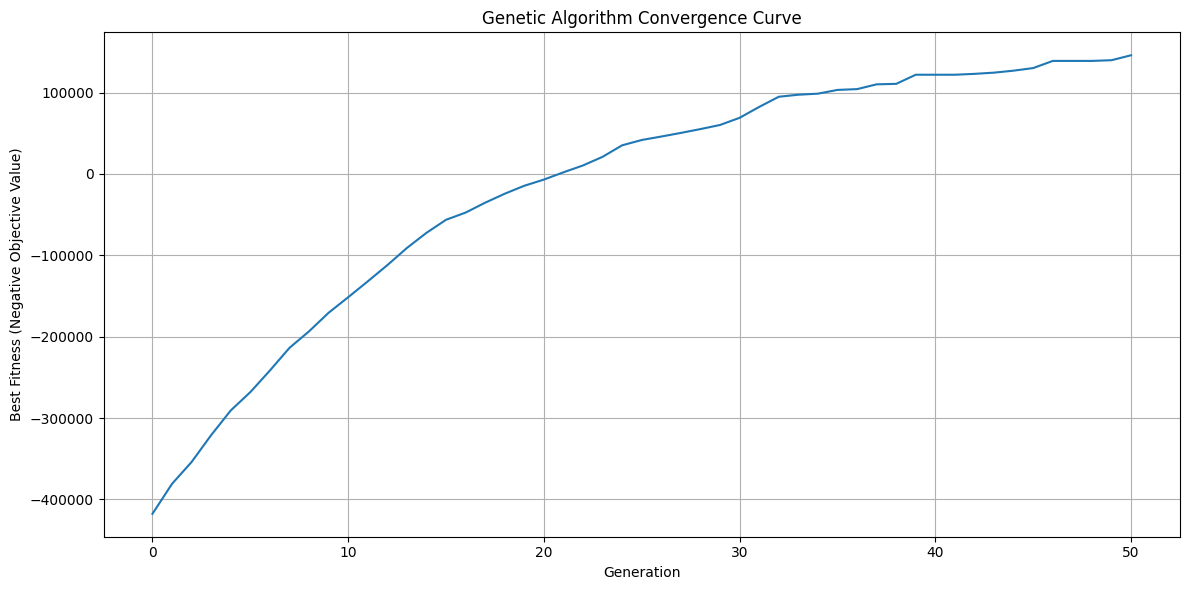

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(ga_instance.best_solutions_fitness)
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Negative Objective Value)")
plt.title("Genetic Algorithm Convergence Curve")
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot 2: Heatmap of Energy Allocation from a Specific Source to All Nodes Over Time

- This visualizes how one source's power is distributed across nodes over time.

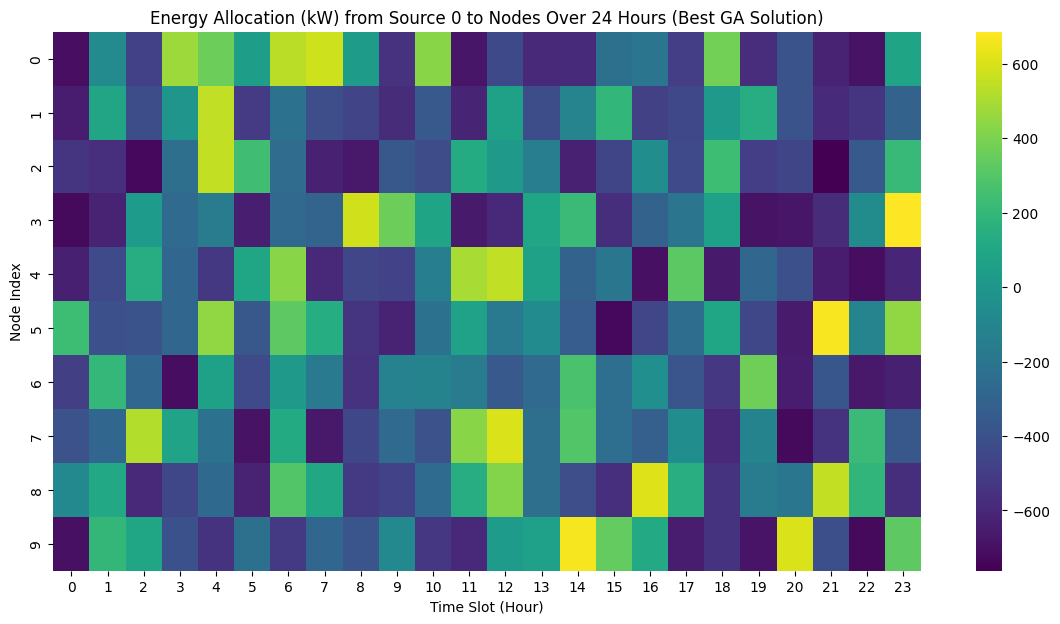

In [ ]:
source_to_plot = 0 # Choose a source (0, 1, or 2)
plt.figure(figsize=(14, 7))
sns.heatmap(best_alloc_energy[source_to_plot, :, :], cmap="viridis", annot=False, fmt=".0f",
            xticklabels=np.arange(time_slots), yticklabels=np.arange(num_nodes))
plt.xlabel("Time Slot (Hour)")
plt.ylabel("Node Index")
plt.title(f"Energy Allocation (kW) from Source {source_to_plot} to Nodes Over 24 Hours (Best GA Solution)")
plt.show()

## Plot 3: Total Demand vs. Total Delivered Energy for a Node Over 24 Hours

-  This shows how well a particular node's demand is met over the day.

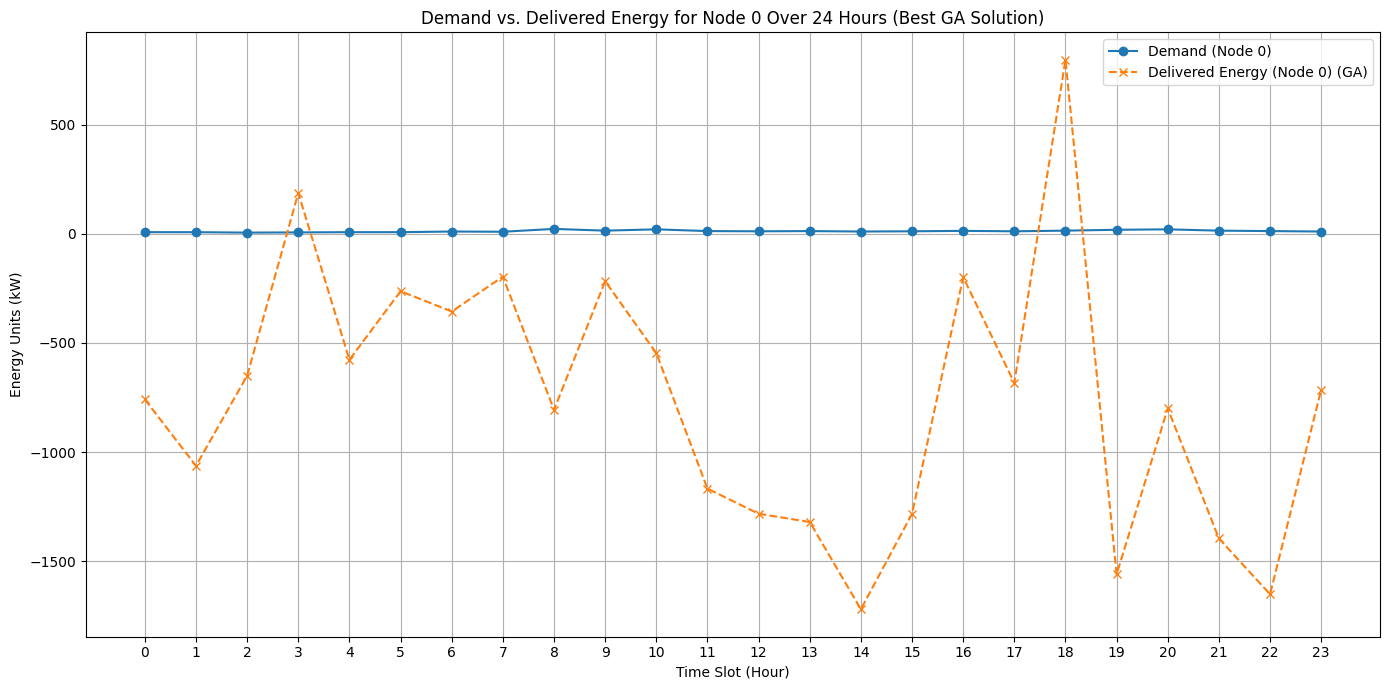

In [ ]:
node_index_to_plot = 0 # Choose a node (0 to num_nodes-1)

# Re-calculate delivered energy for the best GA solution for precise plotting
delivered_energy_per_node_time = np.zeros((num_nodes, time_slots))
for t in range(time_slots):
    for s in range(num_sources):
        for n in range(num_nodes):
            energy_allocated = best_alloc_proportion[s, n, t] * source_capacity[s, t]
            energy_loss = energy_allocated * transmission_loss[s, n]
            energy_received = energy_allocated - energy_loss
            delivered_energy_per_node_time[n, t] += energy_received

total_delivered_node_ga = delivered_energy_per_node_time[node_index_to_plot, :]

plt.figure(figsize=(14, 7))
plt.plot(np.arange(time_slots), demand[node_index_to_plot, :], label=f'Demand (Node {node_index_to_plot})', marker='o', linestyle='-')
plt.plot(np.arange(time_slots), total_delivered_node_ga, label=f'Delivered Energy (Node {node_index_to_plot}) (GA)', marker='x', linestyle='--')
plt.xlabel("Time Slot (Hour)")
plt.ylabel("Energy Units (kW)")
plt.title(f"Demand vs. Delivered Energy for Node {node_index_to_plot} Over 24 Hours (Best GA Solution)")
plt.xticks(np.arange(time_slots))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 5: Source Capacity over 24 hours

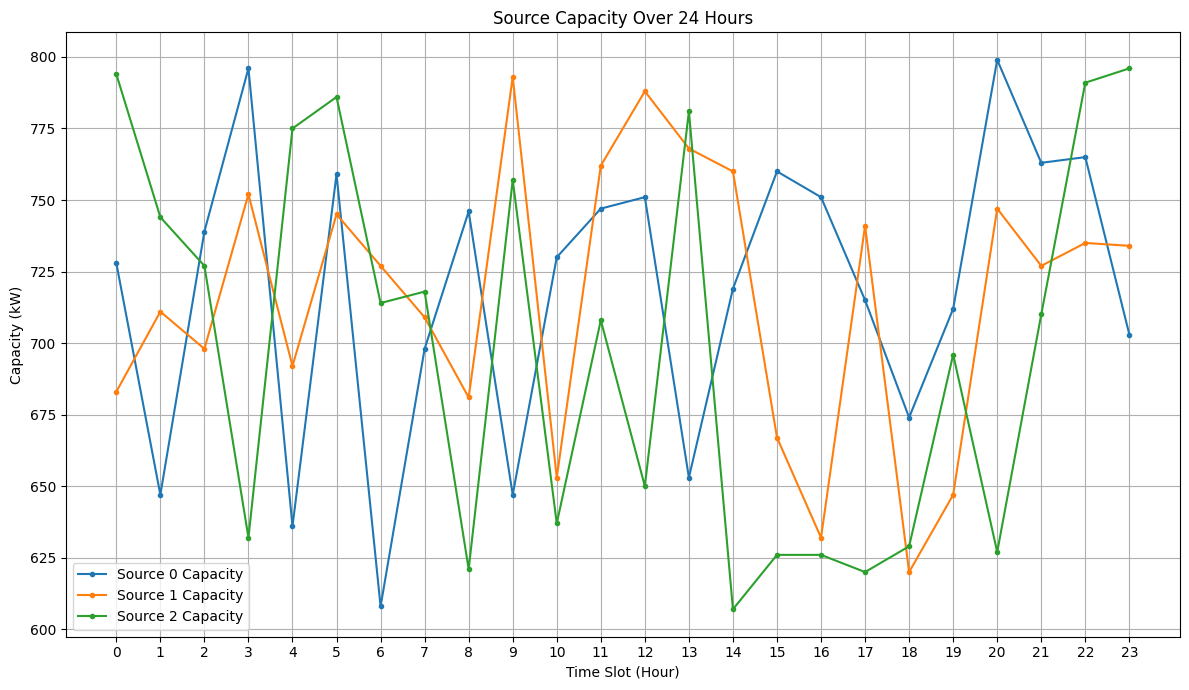

In [ ]:
plt.figure(figsize=(12, 7))
for s in range(num_sources):
    plt.plot(np.arange(time_slots), source_capacity[s, :], label=f'Source {s} Capacity', marker='.')
plt.xlabel("Time Slot (Hour)")
plt.ylabel("Capacity (kW)")
plt.title("Source Capacity Over 24 Hours")
plt.xticks(np.arange(time_slots))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot 6: Potential Energy Cost Per Source Over 24 Hours

- This shows the cost if each source were to provide its full capacity at each time slot.

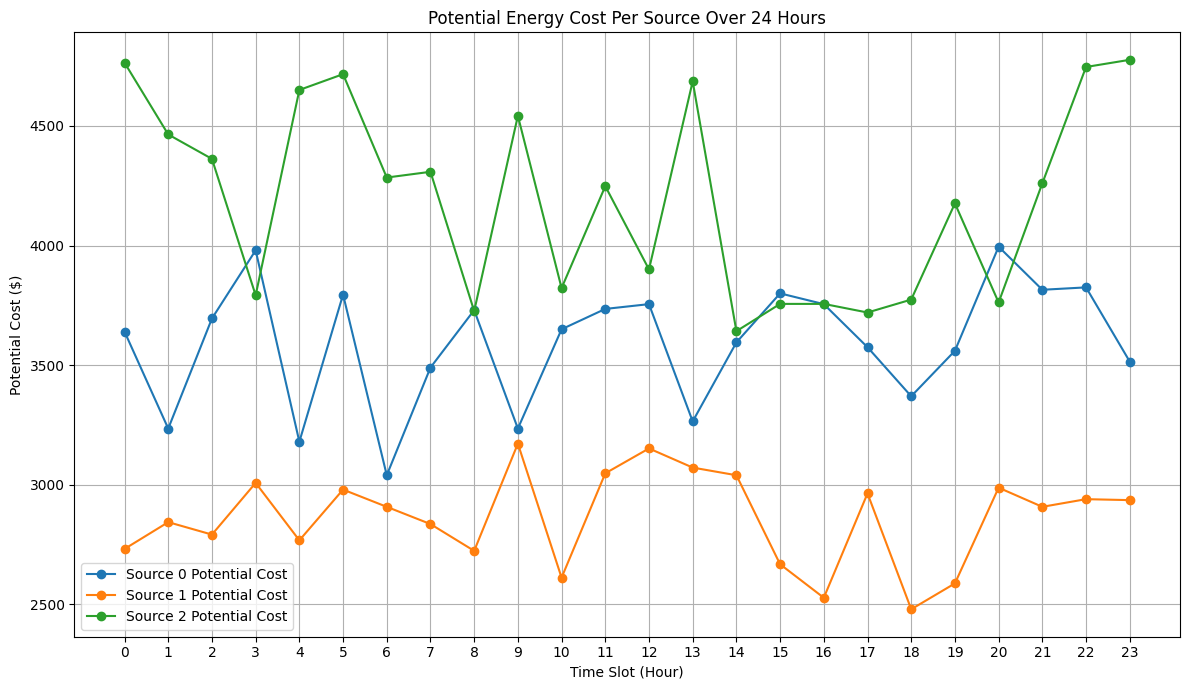

In [ ]:
plt.figure(figsize=(12, 7))
for s in range(num_sources):
    potential_cost = source_capacity[s, :] * source_cost[s]
    plt.plot(np.arange(time_slots), potential_cost, label=f'Source {s} Potential Cost', marker='o')
plt.xlabel("Time Slot (Hour)")
plt.ylabel("Potential Cost ($)")
plt.title("Potential Energy Cost Per Source Over 24 Hours")
plt.xticks(np.arange(time_slots))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Parallel Fitness Evaluation using multiprocessing

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def parallel_fitness(solution):
    return fitness_func(None, solution, 0)

population = [np.random.uniform(0, 1, num_genes) for _ in range(10)]

start_seq = time.time()
sequential_scores = [fitness_func(None, sol, 0) for sol in population]
end_seq = time.time()

start_par = time.time()
with ProcessPoolExecutor() as executor:
    parallel_scores = list(executor.map(parallel_fitness, population))
end_par = time.time()

print("Sequential Time:", end_seq - start_seq)
print("Parallel Time:", end_par - start_par)
print("Speedup:", (end_seq - start_seq) / (end_par - start_par))

Sequential Time: 0.03393363952636719
Parallel Time: 0.07421422004699707
Speedup: 0.45723905074901133


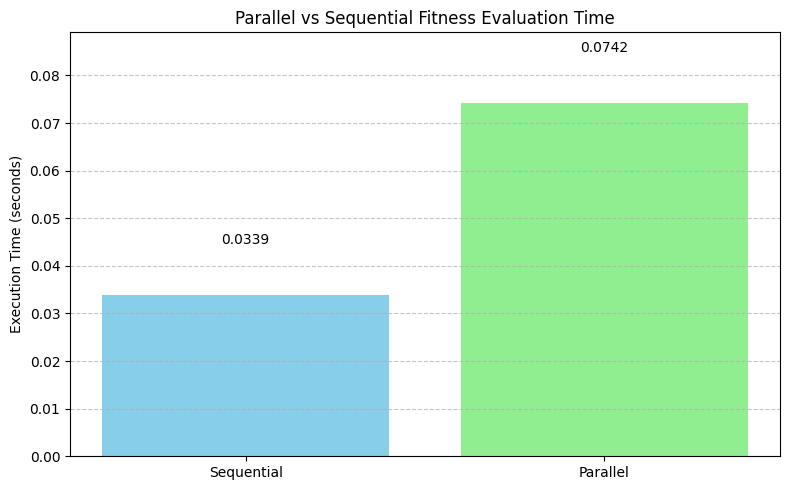

In [ ]:
import matplotlib.pyplot as plt

# Replace these with your actual times if they are stored elsewhere
execution_times = [end_seq - start_seq, end_par - start_par]
methods = ['Sequential', 'Parallel']

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, execution_times, color=['skyblue', 'lightgreen'])
plt.ylabel("Execution Time (seconds)")
plt.title("Parallel vs Sequential Fitness Evaluation Time")

# Annotate bars with actual values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom')

plt.ylim(0, max(execution_times)*1.2)  # Add space above bars
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()